In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

appl = pd.read_csv('AAPL_CLOSE', index_col = 'Date', parse_dates=True)
cisco = pd.read_csv('CISCO_CLOSE', index_col = 'Date', parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE', index_col = 'Date', parse_dates=True)
amzn = pd.read_csv('AMZN_CLOSE', index_col = 'Date', parse_dates=True)

stocks = pd.concat([appl, cisco, ibm, amzn], axis=1)
stocks.columns = ['aapl','cisco','ibm', 'amzn']

stocks.pct_change(1).mean()
stocks.pct_change(1).corr()
stocks.pct_change(1).cov()
log_ret = np.log(stocks/stocks.shift(1))


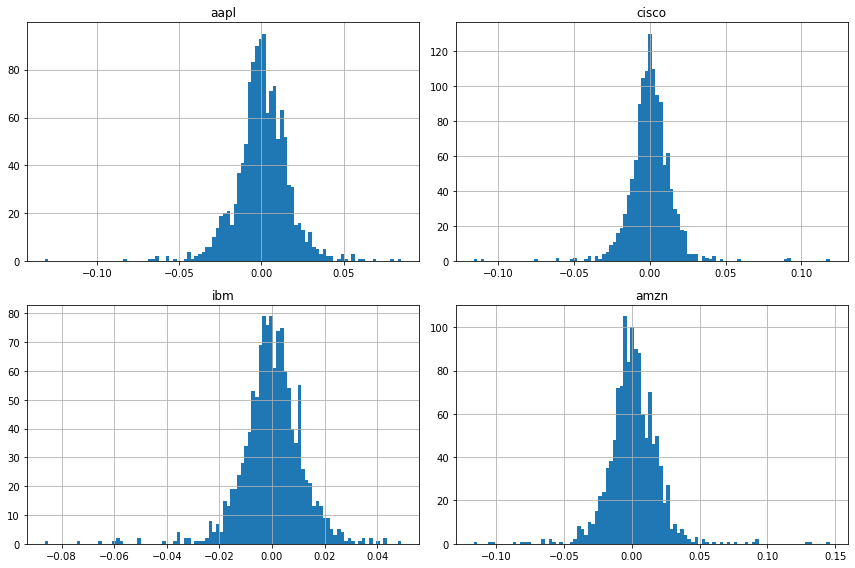

In [14]:
log_ret.hist(bins=100, figsize=(12, 8))
plt.tight_layout()

In [16]:
log_ret.mean()

aapl     0.000614
cisco    0.000497
ibm      0.000011
amzn     0.001139
dtype: float64

In [18]:
log_ret.cov() * 252

,aapl,cisco,ibm,amzn
aapl,0.068326,0.017854,0.014464,0.018986
cisco,0.017854,0.051381,0.018029,0.019956
ibm,0.014464,0.018029,0.035203,0.014939
amzn,0.018986,0.019956,0.014939,0.094470


In [34]:
np.random.seed(101)
print(stocks.columns)

num_ports = 5000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights / np.sum(weights) 
    
    # Save Weights
    all_weights[ind, :] = weights

    #Expected Portfolio Return
    ret_arr[ind] = np.sum( (log_ret.mean()* weights) * 252)

    # Vol
    vol_arr[ind] = np.sqrt( np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharp Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind] 



Index(['aapl', 'cisco', 'ibm', 'amzn'], dtype='object')


In [35]:
sharpe_arr.max()

1.0303260551271067

In [36]:
sharpe_arr.argmax()

1420

In [41]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]
all_weights[sharpe_arr.argmax()]

array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

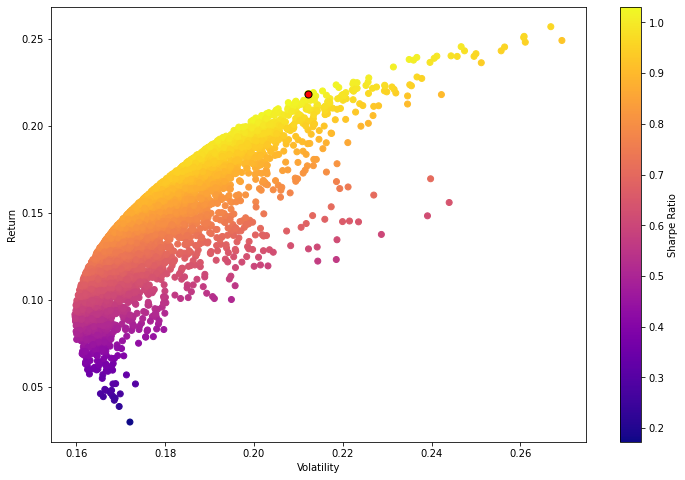

In [42]:
plt.figure(figsize=(12, 8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.scatter(max_sr_vol, max_sr_ret, c='red',s=50, edgecolors='black')

In [54]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt( np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])

from scipy.optimize import minimize

def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    return np.sum(weights) - 1

cons = ({"type": 'eq', 'fun' : check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1))
init_guess = [0.25,0.25,0.25,0.25]
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results

     fun: -1.0307168703346403
     jac: array([ 5.64604998e-05,  4.18424606e-05,  3.39921728e-01, -4.45097685e-05])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.66289779e-01, 2.04189821e-01, 3.56634752e-17, 5.29520400e-01])

In [62]:
opt_results.x

array([2.66289779e-01, 2.04189821e-01, 3.56634752e-17, 5.29520400e-01])

In [63]:
get_ret_vol_sr(opt_results.x)

array([0.21885915, 0.21233683, 1.03071687])

In [64]:
frontier_y = np.linspace(0, 0.3, 100)

def minimize_volatility (weights):
    return get_ret_vol_sr(weights)[1]

frontier_volatility = [];

for possible_return in frontier_y:
    cons = ({'type' : 'eq', 'fun' : check_sum},
            {'type' : 'eq', 'fun' : lambda w : get_ret_vol_sr(w)[0] - possible_return })

In [65]:
result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
frontier_volatility.append(result['fun'])

ValueError: x and y must have same first dimension, but have shapes (1,) and (100,)

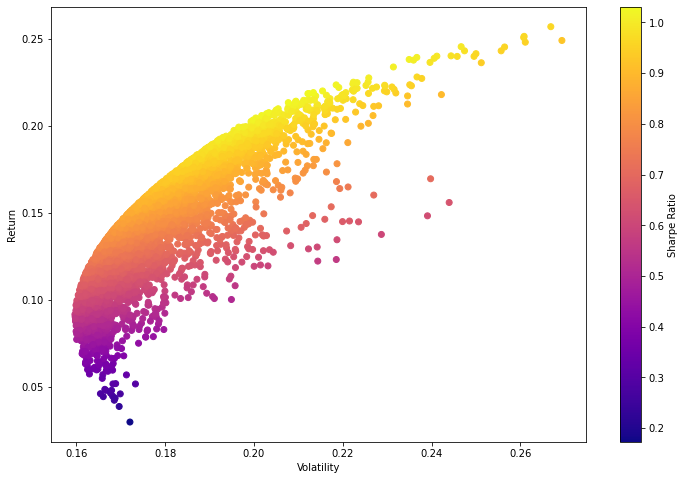

In [68]:
plt.figure(figsize=(12, 8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot(frontier_volatility, frontier_y, 'g--', linewidth= 3)
#frontier_y